# Sensors and Machine learning Activity: Sound Classification

In this activity you will utilize your microphone as a sensor to monitor voice commands. The idea is that on the command 'ON' a given state machine turns into state 1 (which can be sent to a microcontroller for example) and on the command 'OFF' turns into state 0.

In [1]:
#necessary libraries
#!pip install sounddevice numpy scikit-learn python_speech_features

## 1. Recording and playing some audio

In [6]:
import numpy as np
import sounddevice as sd
from sklearn.neighbors import KNeighborsClassifier
from python_speech_features import mfcc
from scipy.io.wavfile import write

# Parameters
fs = 44100  # Sample rate
seconds = 2  # Duration of recording

def record_audio(duration, fs):

    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64')
    sd.wait()  # Wait until recording is finished
    print("Finished recording.")
    return np.squeeze(recording) # Remove channel dimension


audio_on = record_audio(seconds, fs)
audio_off = record_audio(seconds, fs)

Recording...
Finished recording.
Recording...
Finished recording.


## 1.1 Play the Audio to see if it is working

In [7]:
print("Playing On...")
sd.play(audio_on, fs)
sd.wait()
print("Playing Off...")
sd.play(audio_off, fs)
sd.wait()

Playing On...
Playing Off...


## 1.2 Analyze 'On' vs 'Off'

In [8]:
audio_on.shape

(88200,)

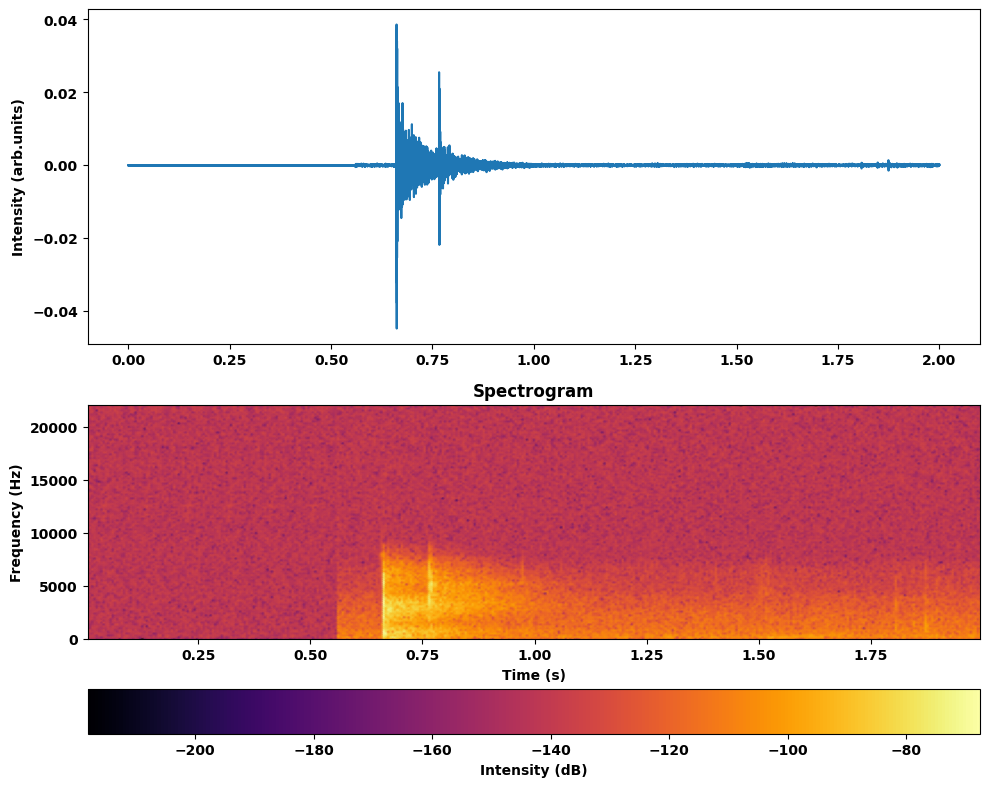

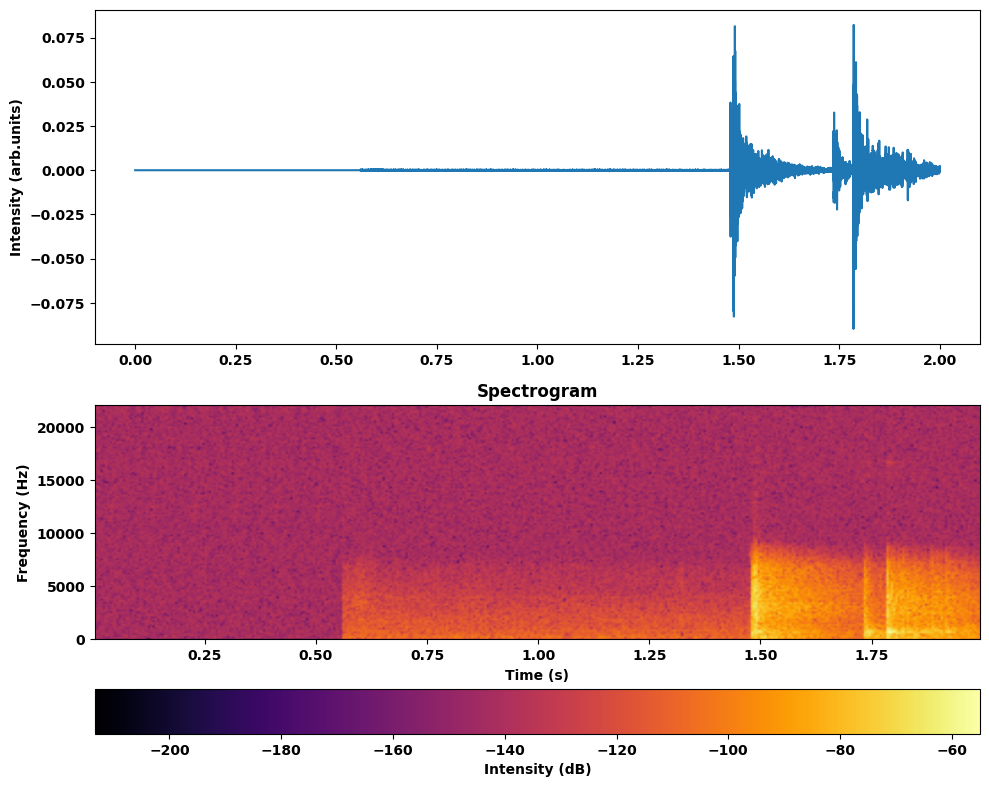

In [9]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

for sig in [audio_on,audio_off]:
    fig,ax = plt.subplots(2,1,figsize=[10,8])
    time = np.linspace(0,sig.shape[0]*1/fs,sig.shape[0])
    ax[0].plot(time,sig)
    ax[0].set_ylabel('Intensity (arb.units)')

    frequencies, times, Sxx = spectrogram(sig, fs)
    im = ax[1].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud',cmap=plt.cm.inferno)
    ax[1].set_ylabel('Frequency (Hz)')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_title('Spectrogram')
    fig.colorbar(im, ax=ax[1],orientation='horizontal',label='Intensity (dB)')
    plt.tight_layout()

## 2. Training a machine learning algorithm

## 2.1 Collecting Data

To train a machine learning algorith the first step is to collect meaningful data. We will then start by collecting 10 recordings of on, off

### 2.1.2. Collect On's

In [104]:
n_records = 10
audios_on = []
for i in range(0,n_records):
    audio_on = record_audio(seconds, fs)
    audios_on.append(audio_on)


Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.


### 2.1.2 Collect Off's

In [105]:
n_records = 10
audios_off = []
for i in range(0,n_records):
    audio_off = record_audio(seconds, fs)
    audios_off.append(audio_off)


Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.


### 2.1.3 Handling datasets the proper way

HDF5 files are interesting tools to collect and store data, as they organize in hierarchical manner into datasets.

We will create a h5 file with python that stores under the key 'On' and 'Off' the arrays corresponding to that, each as a 'Sound_#' + record number

In [113]:
#!pip install h5py

   ---------------------------------------- 2.6/2.6 MB 8.8 MB/s eta 0:00:00


In [119]:
import h5py

with h5py.File('sound_dataset1.h5', 'w') as f:
    on_dataset = f.create_group('On') 
    for i in range(0,len(audios_on)):
        on_dataset['Sound_'+str(i)] = audios_on[i]

    off_dataset = f.create_group('Off') 
    for i in range(0,len(audios_off)):
        off_dataset['Sound_'+str(i)] = audios_off[i]

### Load / Reload data from files

So you can run it in the future without gathering the data again...

In [122]:
audios_on = []
audios_off = []

with h5py.File('sound_dataset1.h5', 'r') as f:
    print(list(f.keys()))
    print(list(f['On'].keys()))
    
    for key in list(f['On'].keys()):
        audios_on.append(np.array(f['On'][key]))

    for key in list(f['On'].keys()):
        audios_off.append(np.array(f['Off'][key]))

['Off', 'On']
['Sound_0', 'Sound_1', 'Sound_2', 'Sound_3', 'Sound_4', 'Sound_5', 'Sound_6', 'Sound_7', 'Sound_8', 'Sound_9']


## 2.2 Feature extraction

Now that we have the data we can advance to the second stage of the development and deployment of a machine learning algorithm: feature extraction.

Feature extraction is important in the context of "Garbage In, Garbage Out": you need to provide information that your algorithm can you to differentiate the signals.

In this case, we see that we need to resort to spectral signatures. In particular, we will utilize the Mel Frequency Cepstral Coefficients (See http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/), but other spectral signatures could be used for that.

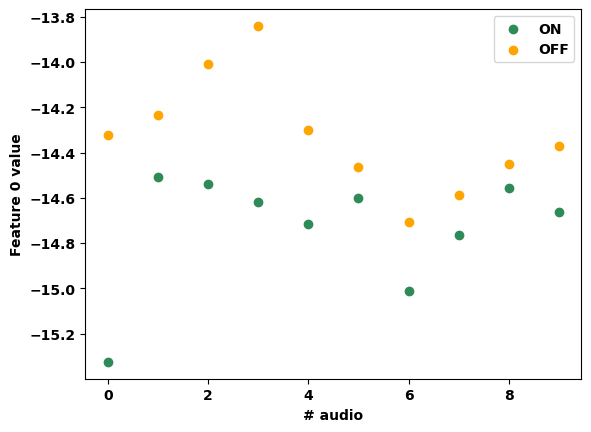

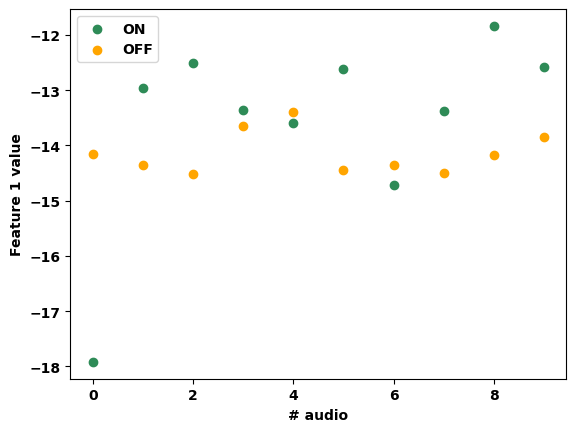

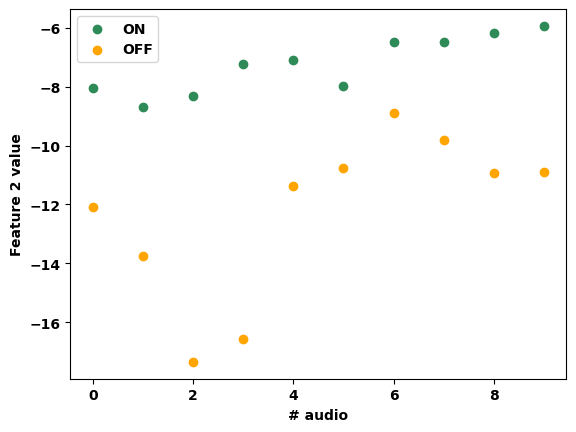

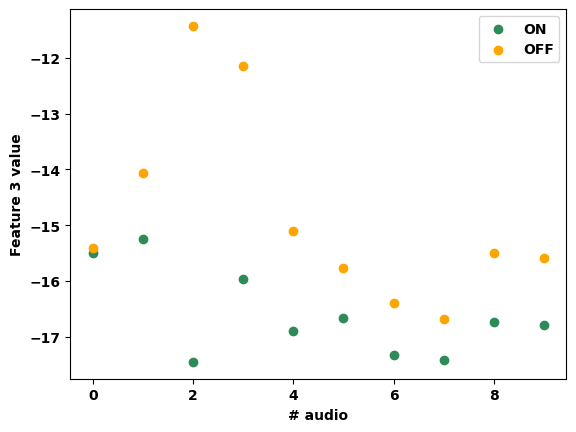

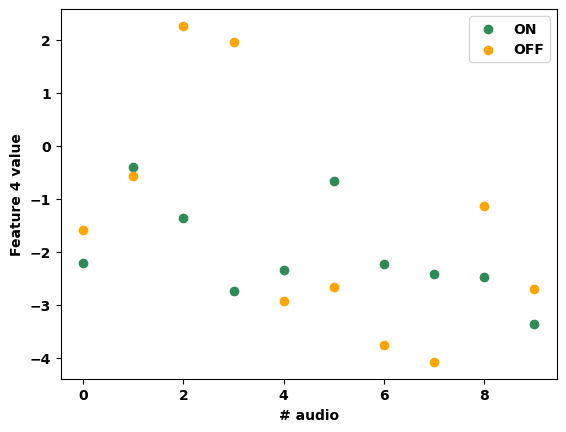

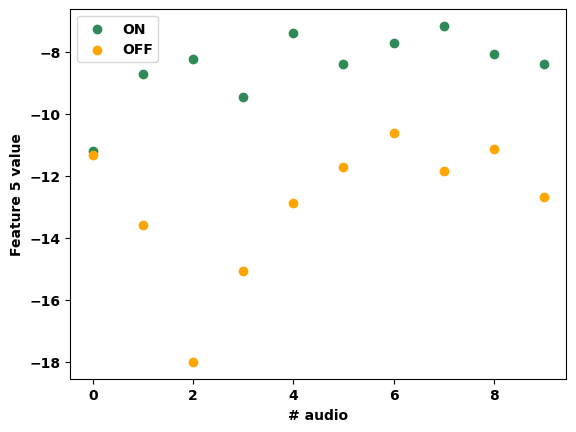

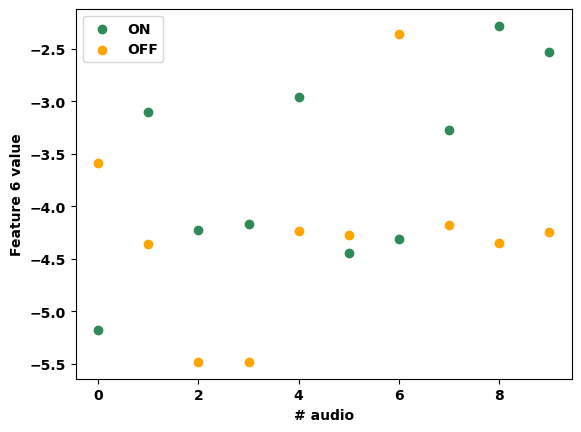

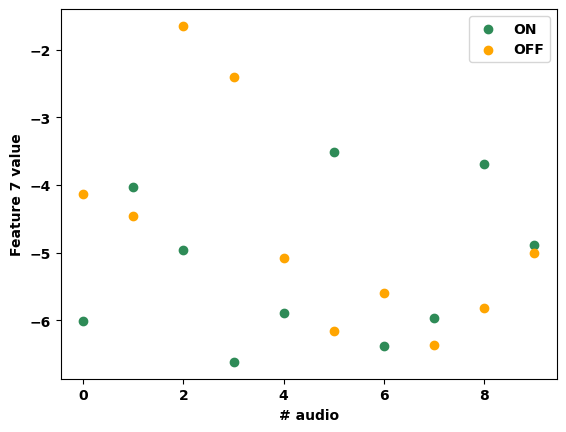

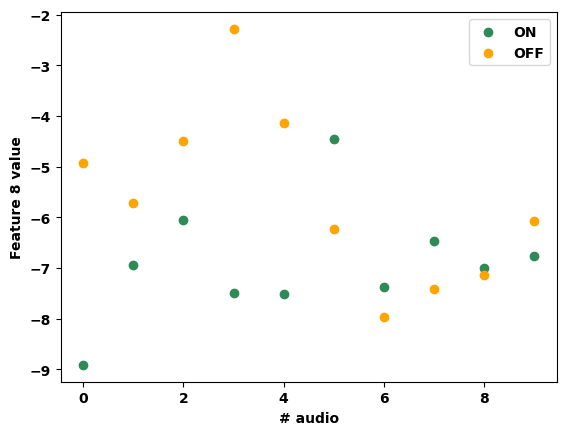

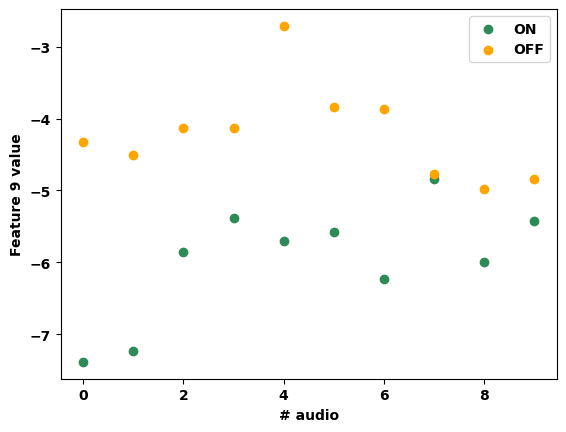

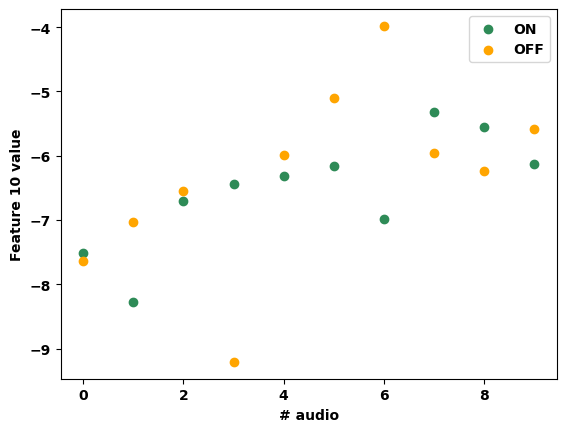

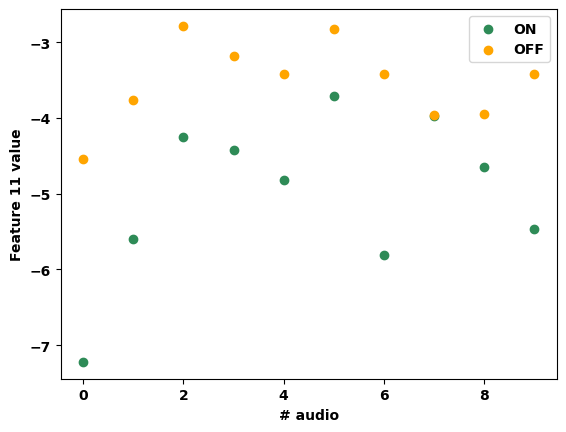

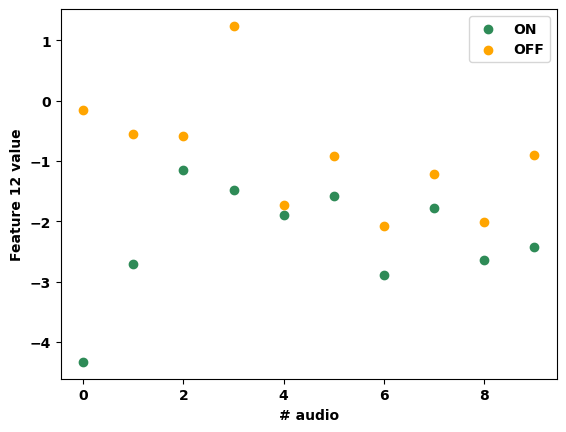

In [123]:
from python_speech_features import mfcc

def extract_features_from_signal(sig,fs):
    """Extract MFCC features from an audio file."""
    mfcc_features = mfcc(sig, samplerate=fs)
    mfcc_mean = np.mean(mfcc_features, axis=0)
    return mfcc_mean


features_on = []
for sig in audios_on:
    mfcc_features = extract_features_from_signal(sig,fs=fs)
    features_on.append(mfcc_features)

features_on = np.array(features_on)


features_off = []
for sig in audios_off:
    mfcc_features = extract_features_from_signal(sig,fs=fs)
    features_off.append(mfcc_features)
    
features_off = np.array(features_off)


for i in range(0,features_on.shape[1]):
    fig,ax = plt.subplots()
    ax.scatter(range(0,features_on.shape[0]),
               features_on[:,i],
               marker='o',color='seagreen',label='ON')
    
    ax.scatter(range(0,features_off.shape[0]),
               features_off[:,i],
               marker='o',color='orange',label='OFF')
    ax.legend()
    ax.set_xlabel('# audio')
    ax.set_ylabel('Feature '+str(i)+' value')


## 2.3. Training the model

So the feature extraction is any good? If it is we can advance to the final step of model development: training and benchmarking.

For this simple activity we will use a K-Nearest Neighbors algorithm applied in the previous feature space.

We will also divide the dataset in train and test datasets to benchmark, i.e. evaluate performance

In [124]:
import numpy as np
import os

from sklearn.neighbors import KNeighborsClassifier


# Parameters
n_neighbors = 4
knn = KNeighborsClassifier(n_neighbors=n_neighbors)


class classifier:

    def __init__(self, model):
        self.model = model

    def fit(self, X, Y,fs=1,keep_features=None):
        new_X = [extract_features_from_signal(sig,fs=fs) for sig in X]
        self.train_X = new_X
        if keep_features != None:
            self.train_X = new_X[:,keep_features]
        self.train_Y = Y
        self.model.fit(self.train_X,self.train_Y)

    def predict(self, X,fs=1,keep_features = None):
        new_X = [extract_features_from_signal(sig,fs=fs) for sig in X]
        if keep_features != None:
            new_X = new_X[:,keep_features]
        return self.model.predict(new_X)

##start model
model = classifier(knn)

##training data
ntrain=5
X_train = np.vstack((audios_on[:ntrain],audios_off[:ntrain])) 
Y_train = np.array(len(audios_on[:ntrain])*[1]+len(audios_off[:ntrain])*[0])

X_test = np.vstack((audios_on[ntrain:],audios_off[ntrain:])) 
Y_test = np.array(len(audios_on[ntrain:])*[1]+len(audios_off[ntrain:])*[0])

model.fit(X_train, Y_train,fs=fs)
predict_train = model.predict(X_train,fs=fs)
predict_test = model.predict(X_test,fs=fs)

print( 'Train Accuracy ', 100*(len(predict_train) - np.count_nonzero(predict_train-Y_train)) / len(Y_train))
print( 'Test Accuracy ', 100*(len(predict_test) - np.count_nonzero(predict_test-Y_test))/ len(Y_test))



Train Accuracy  100.0
Test Accuracy  90.0


## 2.5 Model Packaging 

If you want to package the model for another time, you need to package it. You can do that easily with pickle module.

In [110]:
import pickle

filename = "my_model.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# load model
loaded_model = pickle.load(open(filename, "rb"))

## 2.4 Model deployment

Having the model trained you are now ready to deploy the model as a rolling classifier for your calls! Below we provide a simple example but you can think of having a microcontroller connected to your usb and controlling it by voice commands, or a python interface, etc.

In [111]:
while True:

    audio_data = record_audio(seconds, fs)
    state = loaded_model.predict([audio_data], fs)
    print(f"Predicted State: {'On' if state == 1 else 'Off'}")



Recording...


Finished recording.
Predicted State: On
Recording...


Finished recording.
Predicted State: Off
Recording...


Finished recording.
Predicted State: Off
Recording...


Finished recording.
Predicted State: On
Recording...


KeyboardInterrupt: 

# 3. Now it's your turn

Adapt the code to classify sound of number "1", "2", "3".
Discuss the results.

### 3.1. Collect 1,2,3

In [127]:
n_records = 10
audios_1 = []
for i in range(0,n_records):
    audio_1 = record_audio(seconds, fs)
    audios_1.append(audio_1)


Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.


In [128]:
n_records = 10
audios_2 = []
for i in range(0,n_records):
    audio_2 = record_audio(seconds, fs)
    audios_2.append(audio_2)

Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.


In [129]:
n_records = 10
audios_3 = []
for i in range(0,n_records):
    audio_3 = record_audio(seconds, fs)
    audios_3.append(audio_3)

Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.
Recording...
Finished recording.


In [130]:
from python_speech_features import mfcc

def extract_features_from_signal(sig,fs):
    """Extract MFCC features from an audio file."""
    mfcc_features = mfcc(sig, samplerate=fs)
    mfcc_mean = np.mean(mfcc_features, axis=0)
    return mfcc_mean


## 3.2. Training the model

So the feature extraction is any good? If it is we can advance to the final step of model development: training and benchmarking.

For this simple activity we will use a K-Nearest Neighbors algorithm applied in the previous feature space.

We will also divide the dataset in train and test datasets to benchmark, i.e. evaluate performance

In [131]:
import numpy as np
import os

from sklearn.neighbors import KNeighborsClassifier


# Parameters
n_neighbors = 4
knn = KNeighborsClassifier(n_neighbors=n_neighbors)


class classifier:

    def __init__(self, model):
        self.model = model

    def fit(self, X, Y,fs=1,keep_features=None):
        new_X = [extract_features_from_signal(sig,fs=fs) for sig in X]
        self.train_X = new_X
        if keep_features != None:
            self.train_X = new_X[:,keep_features]
        self.train_Y = Y
        self.model.fit(self.train_X,self.train_Y)

    def predict(self, X,fs=1,keep_features = None):
        new_X = [extract_features_from_signal(sig,fs=fs) for sig in X]
        if keep_features != None:
            new_X = new_X[:,keep_features]
        return self.model.predict(new_X)

##start model
model = classifier(knn)

##training data
ntrain=5
X_train = np.vstack((audios_1[:ntrain],audios_2[:ntrain],audios_3[:ntrain])) 
Y_train = np.array(len(audios_1[:ntrain])*[1]+len(audios_2[:ntrain])*[2]+len(audios_3[:ntrain])*[3])

X_test = np.vstack((audios_1[ntrain:],audios_2[ntrain:],audios_3[ntrain:])) 
Y_test = np.array(len(audios_1[ntrain:])*[1]+len(audios_2[ntrain:])*[2]+len(audios_3[ntrain:])*[3])

model.fit(X_train, Y_train,fs=fs)
predict_train = model.predict(X_train,fs=fs)
predict_test = model.predict(X_test,fs=fs)

print( 'Train Accuracy ', 100*(len(predict_train) - np.count_nonzero(predict_train-Y_train)) / len(Y_train))
print( 'Test Accuracy ', 100*(len(predict_test) - np.count_nonzero(predict_test-Y_test))/ len(Y_test))



Train Accuracy  100.0
Test Accuracy  80.0


## 2.5 Model Packaging 

If you want to package the model for another time, you need to package it. You can do that easily with pickle module.

In [132]:
import pickle

filename = "my_model_numbers.pickle"

# save model
pickle.dump(model, open(filename, "wb"))

# load model
loaded_model = pickle.load(open(filename, "rb"))

## 2.4 Model deployment

Having the model trained you are now ready to deploy the model as a rolling classifier for your calls! Below we provide a simple example but you can think of having a microcontroller connected to your usb and controlling it by voice commands, or a python interface, etc.

In [133]:
while True:

    audio_data = record_audio(seconds, fs)
    state = loaded_model.predict([audio_data], fs)
    print(f"Predicted State: {state}")



Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [3]
Recording...


Finished recording.
Predicted State: [1]
Recording...


Finished recording.
Predicted State: [1]
Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [1]
Recording...


Finished recording.
Predicted State: [1]
Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [3]
Recording...


Finished recording.
Predicted State: [2]
Recording...


Finished recording.
Predicted State: [3]
Recording...


Finished recording.
Predicted State: [1]
Recording...


Finished recording.
Predicted State: [3]
Recording...


Finished recording.
Predicted State: [3]
Recording...


KeyboardInterrupt: 